# Loading Dependencies

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the Excel file

In [138]:
file_path = 'data.xlsx'
df = pd.read_excel(file_path)

# Analysing Data

In [139]:
df.head()

,Match No.,Date,Time (IST),Team A,Team B,Location,Time Zone Diff for Opposition,Gender,League/Event,Rivalry,Series Type,No. of Teams,Match Type,Match Category,Finish Time (IST)
0,1,2024-08-15,1900-01-01 13:59:50,India,Pakistan,India,IST,Men,World Cup,India vs Pakistan,World Cup,10,ODI,International,1900-01-01 21:59:50
1,8,2024-08-15,1900-01-01 13:59:50,India,Pakistan,India,IST,Men,World Cup,India vs Pakistan,World Cup,10,T20I,International,1900-01-01 17:59:50
2,15,2024-08-15,1900-01-01 17:59:50,West Indies,England,West Indies,AST (IST-9.5),Men,ENG tour of WI,NaN,Tri-Series,3,T20I,International,1900-01-01 21:59:50
3,22,2024-08-15,1900-01-01 13:59:50,Sri Lanka,India,Sri Lanka,SLST (IST-0.5),Men,Asia Cup,NaN,4-team Series,4,ODI,International,1900-01-01 21:59:50
4,29,2024-08-15,1900-01-01 13:59:50,England,Pakistan,England,BST (IST-4.5),Men,World Cup,NaN,World Cup,10,T20I,International,1900-01-01 17:59:50


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Match No.                      100 non-null    int64         
 1   Date                           100 non-null    datetime64[ns]
 2   Time (IST)                     100 non-null    datetime64[ns]
 3   Team A                         100 non-null    object        
 4   Team B                         100 non-null    object        
 5   Location                       100 non-null    object        
 6   Time Zone Diff for Opposition  100 non-null    object        
 7   Gender                         100 non-null    object        
 8   League/Event                   100 non-null    object        
 9   Rivalry                        12 non-null     object        
 10  Series Type                    100 non-null    object        
 11  No. of Teams        

In [141]:
df.isna().sum()

Match No.                         0
Date                              0
Time (IST)                        0
Team A                            0
Team B                            0
Location                          0
Time Zone Diff for Opposition     0
Gender                            0
League/Event                      0
Rivalry                          88
Series Type                       0
No. of Teams                      0
Match Type                        0
Match Category                    0
Finish Time (IST)                22
dtype: int64

In [142]:
unique_values = {}
for column in df.columns:
    unique_values[column] = df[column].unique()

unique_values

{'Match No.': array([  1,   8,  15,  22,  29,  36,  43,  50,  57,  64,  71,  78,  85,
         92,   2,   9,  16,  23,  30,  37,  44,  51,  58,  65,  72,  79,
         86,  93,   3,  10,  17,  24,  31,  38,  45,  52,  59,  66,  73,
         80,  87,   4,  11,  18,  25,  32,  39,  46,  53,  60,  67,  74,
         81,  88,   5,  12,  19,  26,  33,  40,  47,  54,  61,  68,  75,
         82,  89,   6,  13,  20,  27,  34,  41,  48,  55,  62,  69,  76,
         83,  90,   7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,
         84,  91,  94,  95,  96,  97,  98,  99, 100]),
 'Date': <DatetimeArray>
 ['2024-08-15 00:00:00', '2024-08-16 00:00:00', '2024-08-17 00:00:00',
  '2024-08-18 00:00:00', '2024-08-19 00:00:00', '2024-08-20 00:00:00',
  '2024-08-21 00:00:00']
 Length: 7, dtype: datetime64[ns],
 'Time (IST)': <DatetimeArray>
 ['1900-01-01 13:59:50', '1900-01-01 17:59:50', '1900-01-01 04:29:50',
  '1900-01-01 14:59:50', '1900-01-01 15:59:50', '1900-01-01 18:59:50',
  '1900-01-01 19:29:5

# Pre-processing

In [143]:
df['Time (IST)'] = pd.to_datetime(df['Time (IST)'], format='%H:%M:%S').dt.time
df['Finish Time (IST)'] = pd.to_datetime(df['Finish Time (IST)'], format='%H:%M:%S').dt.time

df['Match Start'] = df.apply(lambda row: datetime.combine(row['Date'], row['Time (IST)']), axis=1)
df['Match End'] = df.apply(lambda row: datetime.combine(row['Date'], row['Finish Time (IST)']) 
                        if pd.notna(row['Finish Time (IST)']) else pd.NaT, axis=1)

current_time = datetime.now()

In [144]:
def determine_status(row):
    if pd.isna(row['Match End']):
        if current_time < row['Match Start']:
            return 'Upcoming'
        else:
            return 'Completed'
    if current_time < row['Match Start']:
        return 'Upcoming'
    elif row['Match Start'] <= current_time <= row['Match End']:
        return 'Live'
    else:
        return 'Completed'

df['Status'] = df.apply(determine_status, axis=1)
df = df.drop(columns=['Match Start', 'Match End'])

In [145]:
df = df.drop_duplicates(subset=['Date', 'Time (IST)', 'Team A', 'Team B', 'Gender', 'Match Type'], keep='first')

# Setting Priority Score - According to docs

In [146]:
priority = {
    'Series Type': {'World Cup': 1, 'Other': 2},
    'Rivalry': {'Ind vs Pak': 1, 'Ashes': 2, 'Other': 3},
    'Status': {'Live': 1, 'Upcoming': 2, 'Completed': 3, 'Special Match': 4, 'Final': 5, 'Semi-final': 6, 'Quarter-final': 7},
    'Teams': {'India': 1, 'England': 2, 'Australia': 3, 'South Africa': 4, 'Pakistan': 5, 'New Zealand': 6, 'Sri Lanka': 7, 'West Indies': 8, 'Afghanistan': 9, 'Others': 10},
    'Time (IST)': {('17:00', '20:30'): 1, ('12:00', '17:00'): 2, ('20:30', '23:00'): 3, ('09:00', '12:00'): 4, ('23:00', '01:00'): 5, ('01:00', '06:00'): 6, ('06:00', '09:00'): 7},
    'Match Category': {'International': 1, 'Domestic': 2},
    'Format': {'T20': 1, 'ODI': 2, 'Test': 3},
    'Is League': {'Yes': 1, 'No': 2},
    'Gender': {'Male': 1, 'Female': 2}
}

# TRP Calculation Function

In [147]:
def calculate_trp(row):
    trp = 0
    trp += priority['Series Type'].get(row['Series Type'], 2)
    trp += priority['Rivalry'].get(row['Rivalry'], 3)
    trp += priority['Status'].get(row['Status'], 7)
    trp += min(priority['Teams'].get(row['Team A'], 10), priority['Teams'].get(row['Team B'], 10))

    match_time = row['Time (IST)']
    for time_range, score in priority['Time (IST)'].items():
        start_time = datetime.strptime(time_range[0], '%H:%M').time()
        end_time = datetime.strptime(time_range[1], '%H:%M').time()
        if start_time <= match_time <= end_time:
            trp += score
            break

    trp += priority['Match Category'].get(row['Match Category'], 2)
    trp += priority['Format'].get(row['Match Type'], 3)
    trp += priority['Is League'].get(row['League/Event'], 2)
    trp += priority['Gender'].get(row['Gender'], 2)
    trp += row['No. of Teams']

    return trp

In [148]:
df['TRP Priority'] = df.apply(calculate_trp, axis=1)

In [149]:
df = df.sort_values(by='TRP Priority')
df

,Match No.,Date,Time (IST),Team A,Team B,Location,Time Zone Diff for Opposition,Gender,League/Event,Rivalry,Series Type,No. of Teams,Match Type,Match Category,Finish Time (IST),Status,TRP Priority
10,71,2024-08-15,18:59:50,India,Australia,India,IST,Men,AUS tour of IND,NaN,Bilateral,2,T20I,International,22:59:50,Completed,20
24,72,2024-08-16,18:59:50,India,Australia,India,IST,Men,AUS tour of IND,NaN,Bilateral,2,T20I,International,22:59:50,Completed,20
51,74,2024-08-18,12:59:50,Australia,India,Australia,ACST (IST+4),Men,IND tour of AUS,NaN,Bilateral,2,ODI,International,16:59:50,Completed,20
38,73,2024-08-17,18:59:50,India,Australia,India,IST,Men,AUS tour of IND,NaN,Bilateral,2,T20I,International,22:59:50,Completed,20
31,24,2024-08-17,13:59:50,India,Bangladesh,Bangladesh,BST (IST-0.5),Men,IND tour of BAN,NaN,Bilateral,2,T20I,International,17:59:50,Completed,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,2024-08-20,15:14:50,Trichy Grand Cholas,Dindigul Dragons,India,IST,Men,TNPL,NaN,League,9,T20I,Domestic,19:14:50,Completed,38
7,50,2024-08-15,04:29:50,St Kitts & Nevis,Jamaica Tallawahs,West Indies,AST (IST-9.5),Men,CPL,NaN,League,6,T20I,Domestic,08:29:50,Completed,39
82,21,2024-08-21,04:29:50,St Kitts & Nevis,Jamaica Tallawahs,West Indies,AST (IST-9.5),Men,CPL,NaN,League,6,T20I,Domestic,08:29:50,Completed,39
13,92,2024-08-15,16:59:50,Netherlands Women,Sri Lanka Women,India,IST,Women,ICC Women's T20 World Cup Qualifier Warm-up Ma...,NaN,League,12,T20I,International,20:59:50,Completed,40


In [150]:
current_time = pd.Timestamp('now').strftime('%H:%M')
df_filtered = df[(df['Status'] != 'Completed') | ((df['Status'] == 'Completed') & ('08:00' <= current_time <= '20:00'))]

# Visualization

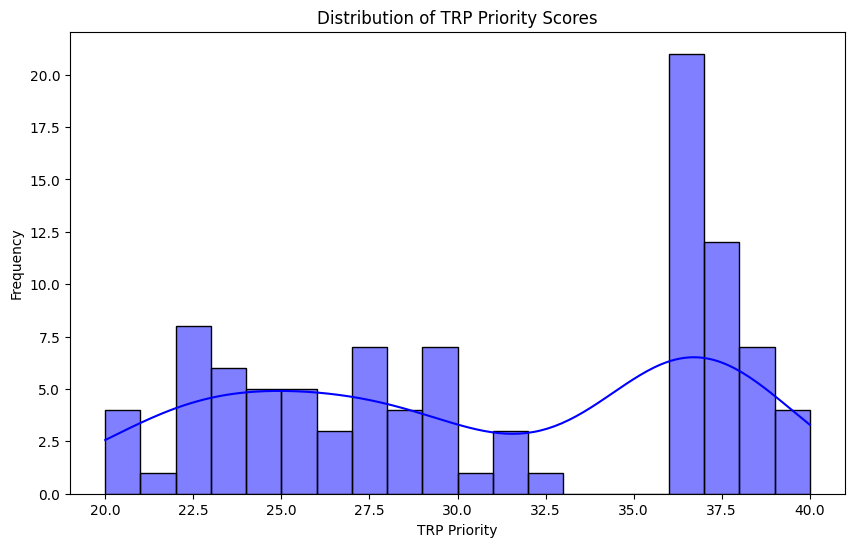

In [151]:
plt.figure(figsize=(10, 6))
sns.histplot(df['TRP Priority'], bins=20, kde=True, color='blue')
plt.title('Distribution of TRP Priority Scores')
plt.xlabel('TRP Priority')
plt.ylabel('Frequency')
plt.show()

C:\Users\karti\AppData\Local\Temp\ipykernel_13664\3810435522.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Date', y='High Priority Matches', data=date_priority, palette='viridis')


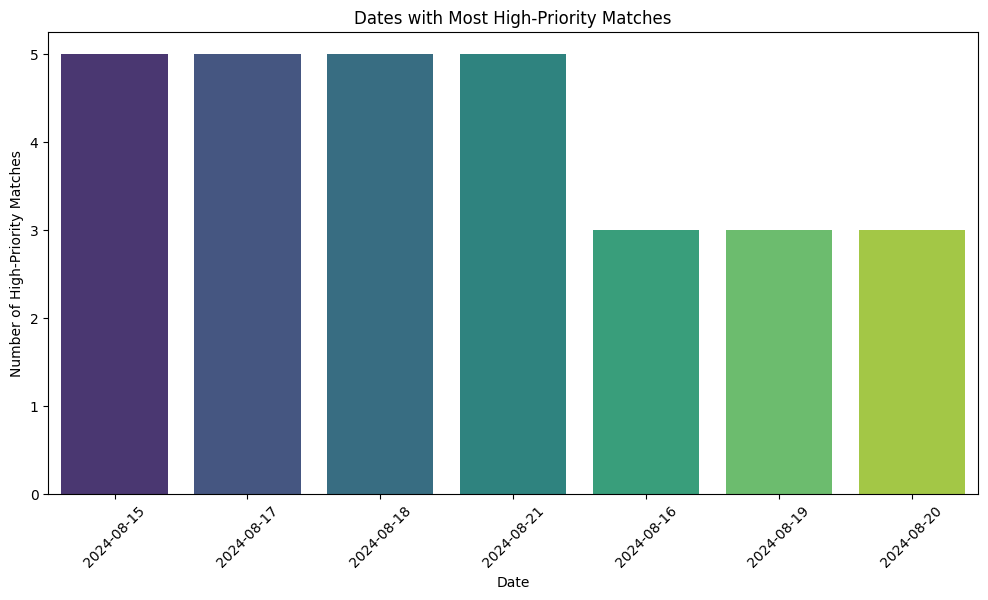

In [157]:
df['High Priority'] = df['TRP Priority'] <= df['TRP Priority'].quantile(0.25)
date_priority = df[df['High Priority']].groupby('Date').size().reset_index(name='High Priority Matches')

date_priority = date_priority.sort_values(by='High Priority Matches', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Date', y='High Priority Matches', data=date_priority, palette='viridis')
plt.title('Dates with Most High-Priority Matches')
plt.xlabel('Date')
plt.ylabel('Number of High-Priority Matches')
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='TRP Priority', ylabel='Team'>

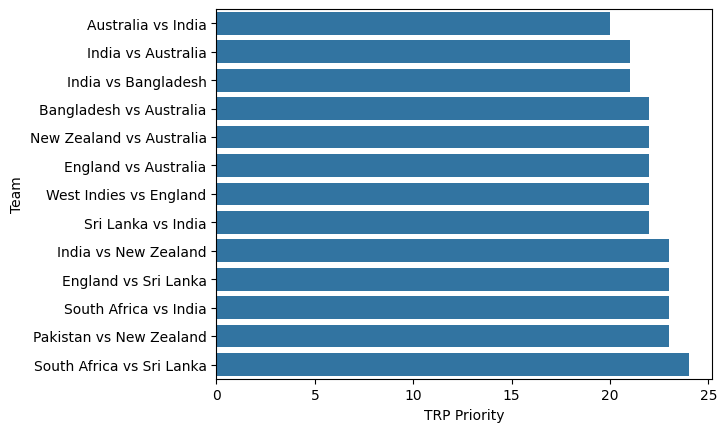

In [163]:
df['Team'] = df[['Team A', 'Team B']].apply(lambda x: ' vs '.join(x), axis=1)
team_trp = df.head(20).groupby('Team')['TRP Priority'].mean().sort_values()
sns.barplot(x=team_trp, y=team_trp.index)